In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [15]:
series = pd.read_csv("../lecture 1/Архив/Series/weekly-closings-of-the-dowjones-.csv")['Close']
series_not_stat = series

In [16]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


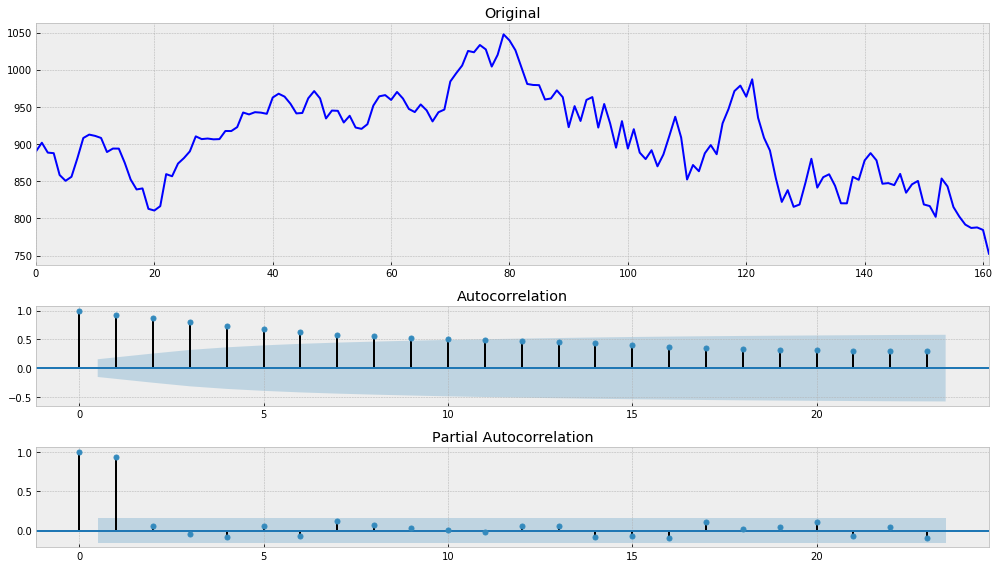

In [18]:
tsplot(series)

In [19]:
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


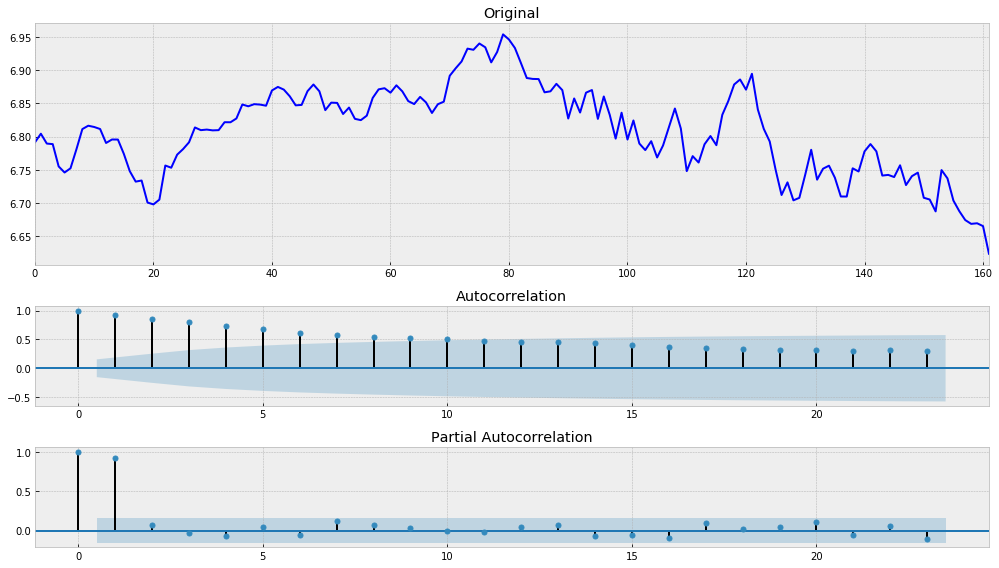

In [20]:
tsplot(series)

In [21]:
series = series[1:] - series[:-1]

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


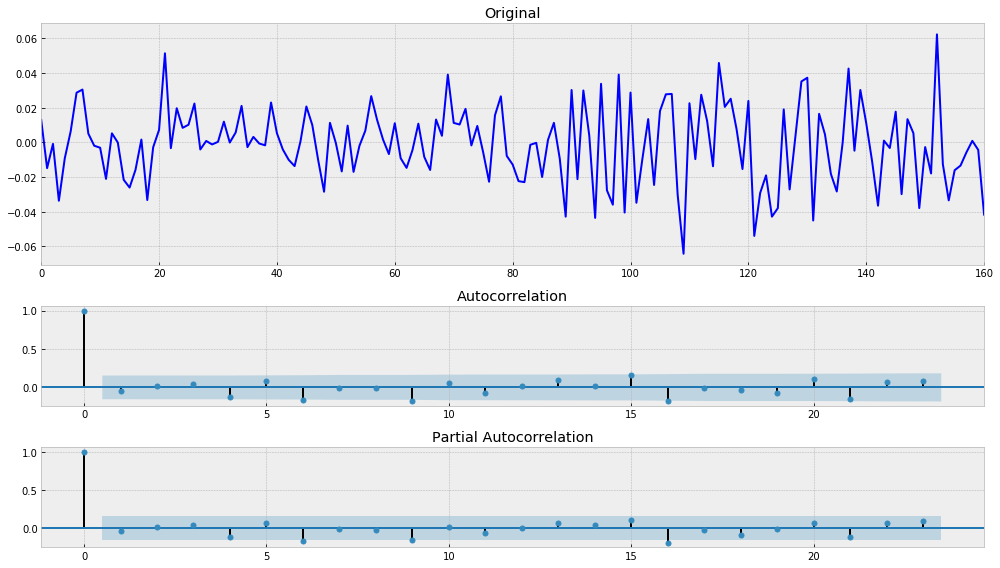

In [22]:
tsplot(series)

In [23]:
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -3.433413
p-value                          0.009871
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


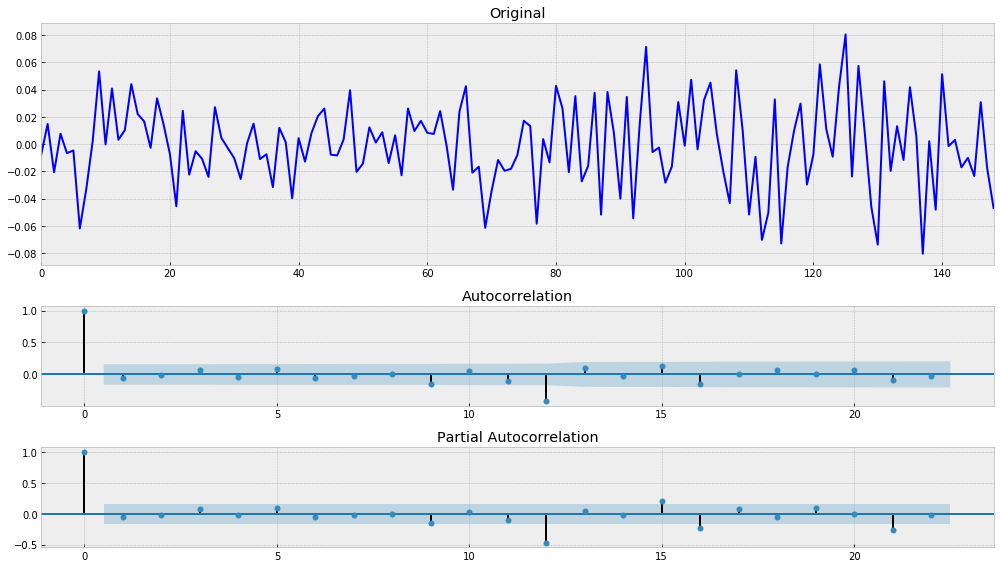

In [24]:
tsplot(series)

Добились p value меньше 0.05 и превратили ряд в стационарный

# Начало дз 2

In [70]:


from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [71]:
series = pd.Series(series)
series_not_stat = pd.Series(series_not_stat)

In [72]:
# Скользящее среднее

In [73]:
#  стационарый ряд

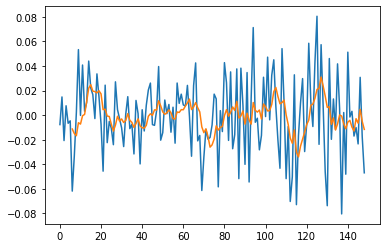

In [74]:

plt.plot(series)
plt.plot(series.rolling(7).mean())

In [75]:
mean_squared_error(series[6:], series.rolling(7).mean().dropna())

0.000832513261595963

In [76]:
#  Не стационарый ряд

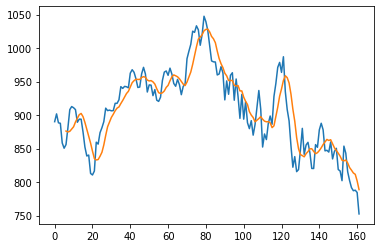

In [77]:
plt.plot(series_not_stat)
plt.plot(series_not_stat.rolling(7).mean())

In [78]:
mean_squared_error(series_not_stat[6:], series_not_stat.rolling(7).mean().dropna())

697.768282548401

In [79]:
# Взвешенное скользящее среднее

In [80]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)

In [81]:
mean_squared_error(series[6:], weighted_moving_average(series, 7, [2,4,8,16,32,64,128]).dropna())

0.0003291763822360079

In [82]:
mean_squared_error(series_not_stat[6:],weighted_moving_average(series_not_stat, 7, [2,4,8,16,32, 64, 128]).dropna())

123.78792143638405

In [83]:
# видим значительное улучшение при использовании взвешенной MA

In [84]:
# Экспоненциальная модель

In [85]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [86]:
train, test = series[:int(len(series)*0.7)], series[int(len(series)*0.7):]
def mse(X):
    a = X
    result = exponential_moving_average(train, a)
    predict = result[-len(test):]
    return mean_squared_error(predict, test)
  
opt = minimize(mse, x0=[0], method="L-BFGS-B")
a_opt = opt.x

In [87]:
mean_squared_error(series[6:], exponential_moving_average(series, a_opt)[6:])

0.000994536373729175

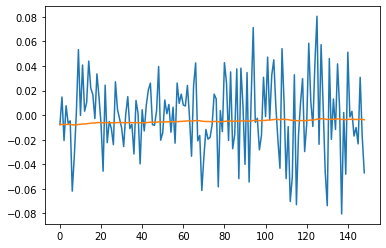

In [88]:
plt.plot(series)
plt.plot(exponential_moving_average(series, a_opt))

In [89]:
train, test = series_not_stat[:int(len(series_not_stat)*0.7)], series_not_stat[int(len(series_not_stat)*0.7):]

opt = minimize(mse, x0=[0], method="L-BFGS-B")
a_opt = opt.x

In [90]:
mean_squared_error(series_not_stat[6:], exponential_moving_average(series_not_stat, a_opt)[6:])

6485.418172494156

In [91]:
# Стало хуже в обоих случаях


In [102]:
ts = series

In [103]:
# Двойное экспоненциальное сглаживание

In [104]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [111]:
train, test = series[:int(len(series)*0.7)], series[int(len(series)*0.7):]
def mse(X):
    a, b = X
    result = double_ema(train, a, b)
    predict = result[-len(test):]
    return mean_squared_error(predict, test)
  
opt = minimize(mse, x0=[0, 0], method="L-BFGS-B", bounds=((0,1),(0,1)))
a_opt, b_opt = opt.x

In [114]:
mean_squared_error(series[6:], double_ema(series, a_opt, b_opt)[6:])

0.0006493783125602212

In [115]:
def plot_dema(alpha, beta, orig):
    dema = double_ema(orig, 0.2, 0.2)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(orig, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

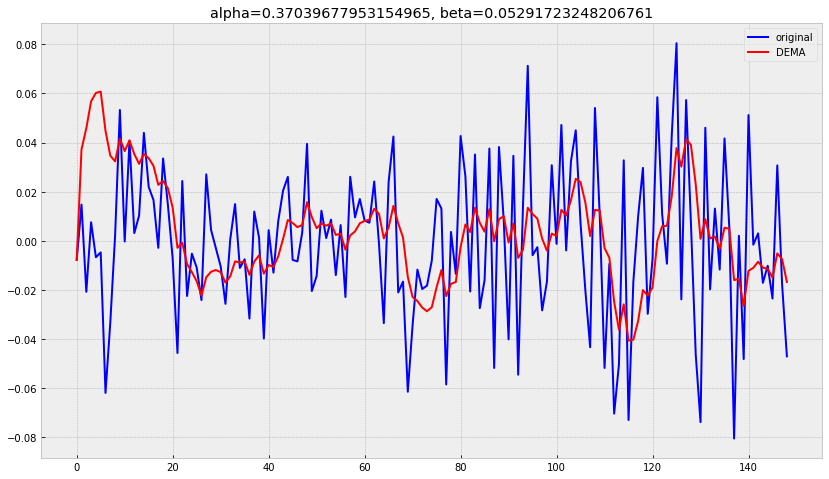

In [117]:
plot_dema(a_opt, b_opt, series)

In [118]:
train, test = series_not_stat[:int(len(series_not_stat)*0.7)], series_not_stat[int(len(series_not_stat)*0.7):]
def mse(X):
    a, b = X
    result = double_ema(train, a, b)
    predict = result[-len(test):]
    return mean_squared_error(predict, test)
  
opt = minimize(mse, x0=[0, 0], method="L-BFGS-B", bounds=((0,1),(0,1)))
a_opt, b_opt = opt.x

In [119]:
mean_squared_error(series_not_stat[6:], double_ema(series_not_stat, a_opt, b_opt)[6:])

154.2659572061385

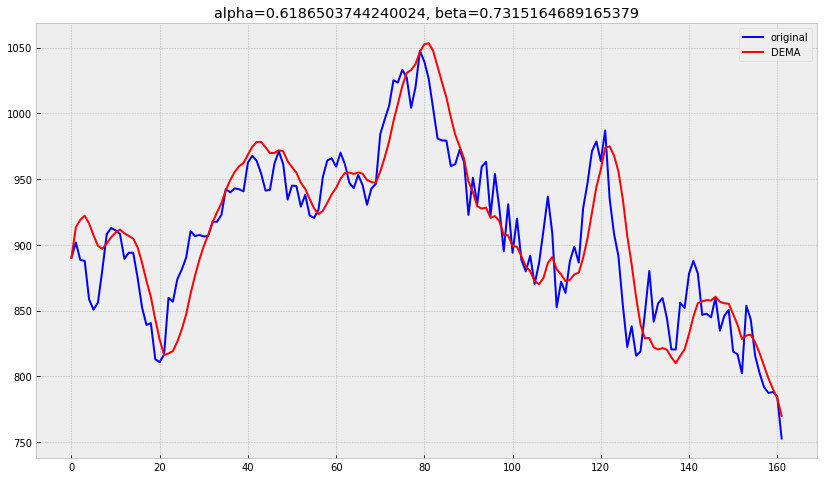

In [120]:
plot_dema(a_opt, b_opt, series_not_stat)

In [121]:
# Самые лучшие результаты на нестациоонарном ряде получились при двойном экспоненциальном сглаживании

In [122]:
# Самые лучшие результаты на стационарном ряде получились при взвешенном скользящем среднем